In [1]:
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import os.path
from os import path
import matplotlib.pyplot as plt
%matplotlib inline
import json

import itertools
import scipy.stats as scs
from scipy.spatial.distance import pdist, squareform

from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.cm as cm
from IPython.display import HTML, display
spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

import pickle

from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Save Model

In [640]:
# save the model to disk
model_name = 'gm_70000_final'
filename = f'./models/{model_name}.sav'
pickle.dump(gm, open(filename, 'wb'))
 


In [330]:
model_name = 'gm_10000_final'
filename = f'./models/{model_name}.sav'
# load the model from disk
gm = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

FileNotFoundError: [Errno 2] No such file or directory: './models/gm_10000_final.sav'

### Load Playlist Data with Song Analysis Data Appended

In [2]:
playlist_master = pd.read_csv('./csv/playlist_master.csv', index_col=0)

/home/george/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
playlist_master.groupby(['playlist_name','num_tracks']).count().shape

(69429, 22)

In [4]:
playlist_master.shape

(6290606, 24)

### Make Playlist Analysis Dataframe - playlist_X

In [3]:
def playlist_X(df):
    '''
    Format playlist with numerical song analysis data to playlist stats DF for X input matrix
    
    
    '''
    
#     df.drop(columns='Unnamed: 0.1', inplace=True)
    playlist_X = df[['playlist_name','danceability',
                     'key','loudness','mode','speechiness','acousticness','instrumentalness',
                     'liveness','valence','tempo', 'num_tracks']]
    playlist_X_stats = playlist_X.groupby(['playlist_name','num_tracks']).agg({'danceability': [np.std, np.mean],
                                                                'loudness': [np.std, np.mean],
                                                                'mode': [np.std, np.mean],
                                                                'speechiness': [np.std, np.mean],
                                                                'acousticness': [np.std, np.mean],
                                                                'instrumentalness': [np.std, np.mean],
                                                                'liveness': [np.std, np.mean],
                                                                'valence': [np.std, np.mean],
                                                                'tempo': [np.std, np.mean]}).reset_index(level=1)
    playlist_X_stats.dropna(inplace=True)
    playlist_X_stats.drop(columns='num_tracks', inplace=True)
    return playlist_X_stats

In [60]:
playlist_analysis = playlist_X(playlist_master)

/home/george/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [8]:
playlist_analysis.shape

(69422, 18)

### Standard Scaler

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mstats = scaler.fit_transform(playlist_analysis.iloc[:,:])

### ~~MinMax Scaler~~

In [858]:
from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()
mstats = scaler.fit_transform(playlist_analysis)

### PCA

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10) #pca object
mstats = pca.fit_transform(mstats)
evr = pca.explained_variance_ratio_
print(evr)
print("The 12 principal components explain {0:0.1f}%"
      " of the variance in the original data.".format(evr.sum()*100))

[0.2892046  0.14619396 0.10404057 0.09211588 0.0762472  0.06116825
 0.04278711 0.03876188 0.02979063 0.02738628]
The 12 principal components explain 90.8% of the variance in the original data.


Test for Cumulative Variance & Choose Num Features

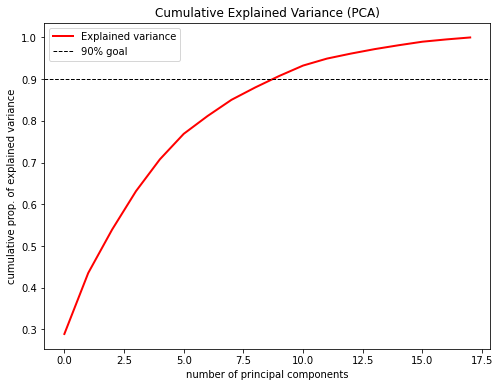

In [305]:
total_variance = np.sum(pca.explained_variance_)
cum_variance = np.cumsum(pca.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color='red', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', color="black", linewidth=1)
ax.set_ylabel('cumulative prop. of explained variance')
ax.set_xlabel('number of principal components')
ax.legend();
plt.title('Cumulative Explained Variance (PCA)')
# plt.savefig('./img/cumulative_var_pca.png', dpi=200)

## Kmeans Sample

### **Gaussian Mixture Sample**

In [7]:
from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=k, n_init=10)
# y = gm.fit(x)


### ~~Bayesian Mixture Sample~~

In [451]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=k, n_init=10)


### ~~DBSCAN Sample~~

In [463]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=.2, min_samples=5)
# y = dbscan.fit(x)
# dbscan.labels_

### **NearestNeighbors Sample**

In [8]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm = 'auto')
knn.fit(mstats)


NearestNeighbors()

Define Model

## Evaluate Kmeans - cluster_testing

In [15]:
def cluster_testing(df_scaled_pca, maxk, model):
    x = np.array(mstats)
    wcss = np.zeros(maxk)
    silhouette = np.zeros(maxk)

#     fig, axes = plt.subplots(5, 4, figsize=(16,9))

    # flatten
#     axes = [ax for axrow in axes for ax in axrow]

    for k in range(1,maxk):
        
        y = model.fit_predict(x)
    #     ax.axis('off')
    #     ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    #     ax.set_ylim(ymin=-9, ymax=8)


        for c in range(0, k):
            for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
                wcss[k] += sum(x[i1] - x[i2])**2
        wcss[k] /= 2

        if k > 1:
            silhouette[k] = silhouette_score(x,y)
    
    fig, ax = plt.subplots()
    ax.plot(range(2,maxk), wcss[2:maxk], 'o-')
    ax.set_xlabel("number of clusters")
    ax.set_ylabel("within-cluster sum of squares")
    plt.title('Inertia Graph')
    
    fig2, ax2 = plt.subplots()
    ax2.plot(range(2,maxk), silhouette[2:maxk], 'o-')
    ax2.set_xlabel("number of clusters")
    ax2.set_ylabel("silhouette score")
    #ax.set_ylim(ymin=0.0, ymax=1.0)

    return (maxk, wcss, silhouette)

Run cluster_testing

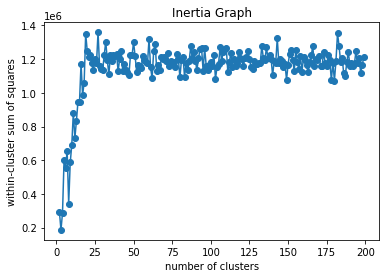

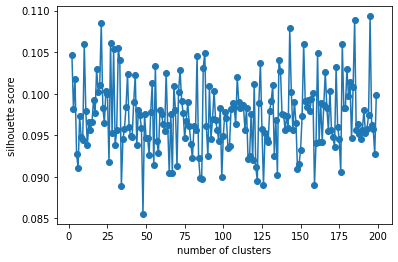

In [438]:
maxk, wcss, silhouette = cluster_testing(mstats, 30, KMeans(n_clusters=k,
                init='k-means++',
                n_init=20,
                max_iter=3000,
                tol=0.0001,
                precompute_distances='deprecated',
                copy_x=True,
                algorithm='auto'))

Generate Silhouette Plot

For n_clusters = 2 The average silhouette_score is : 0.20693747531254872


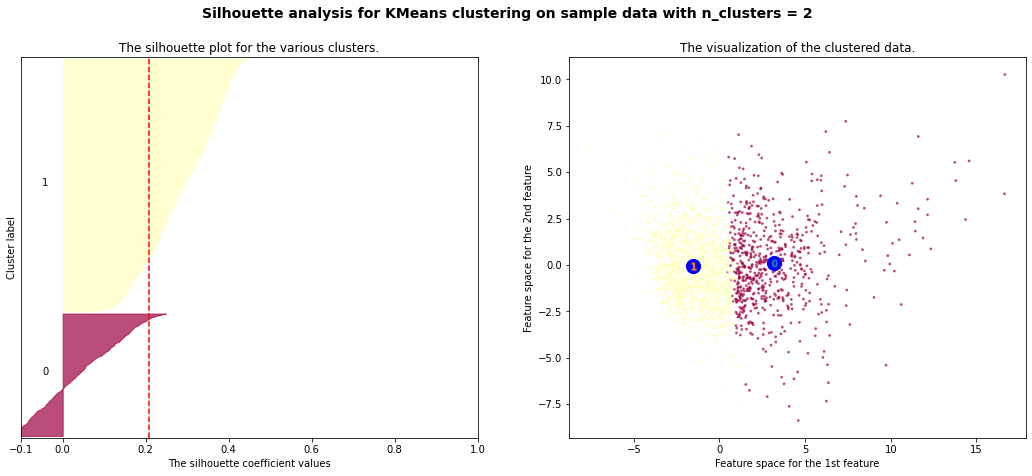

For n_clusters = 3 The average silhouette_score is : 0.12573720658925372


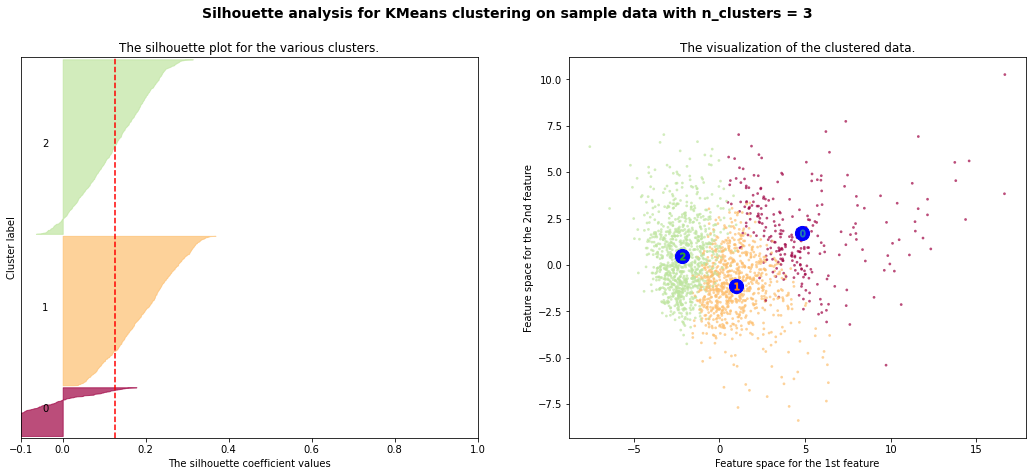

For n_clusters = 4 The average silhouette_score is : 0.13792576462300607


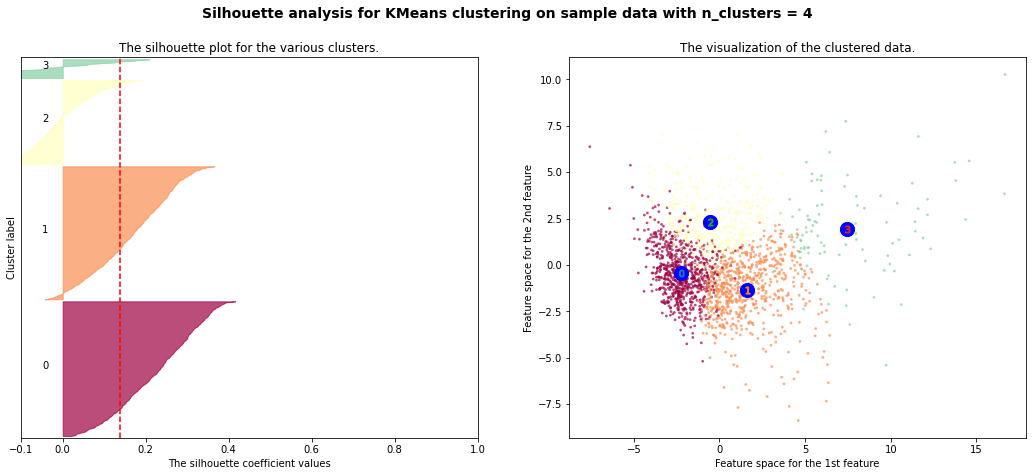

For n_clusters = 5 The average silhouette_score is : 0.12014475435338093


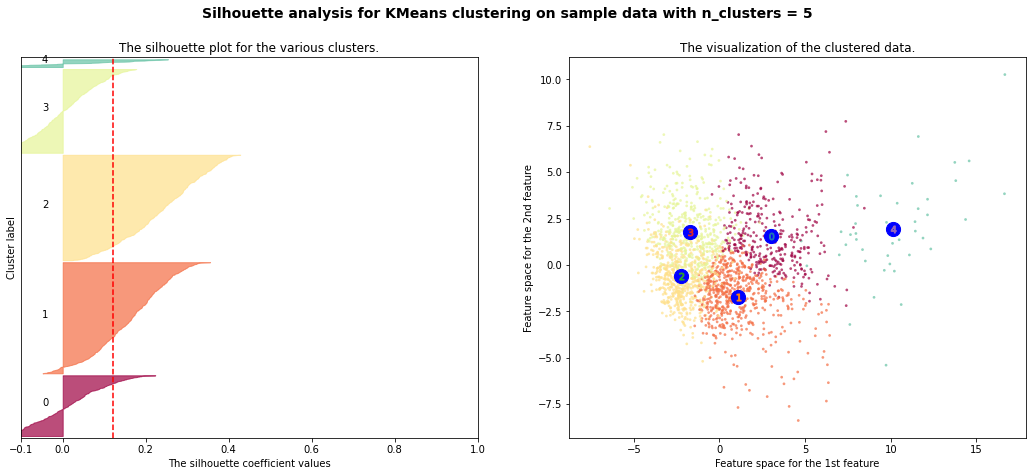

For n_clusters = 6 The average silhouette_score is : 0.12412671560814846


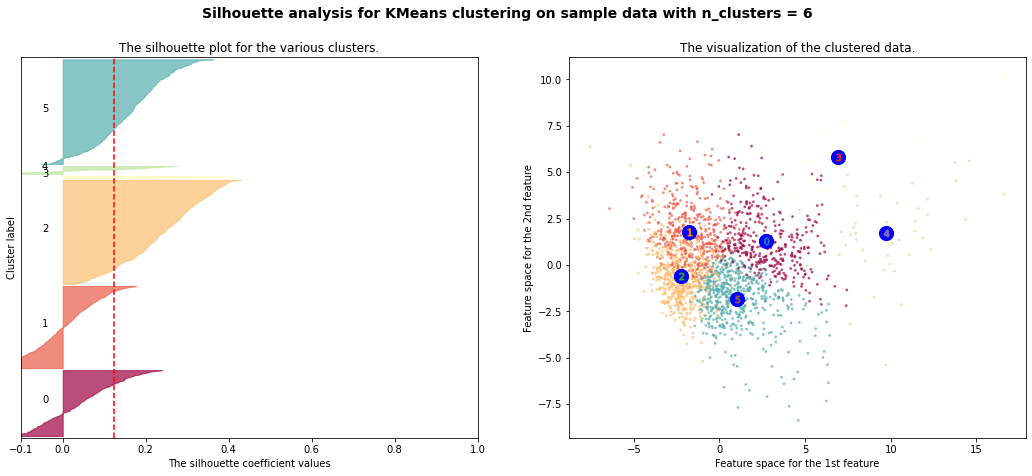

For n_clusters = 7 The average silhouette_score is : 0.1260917595968942


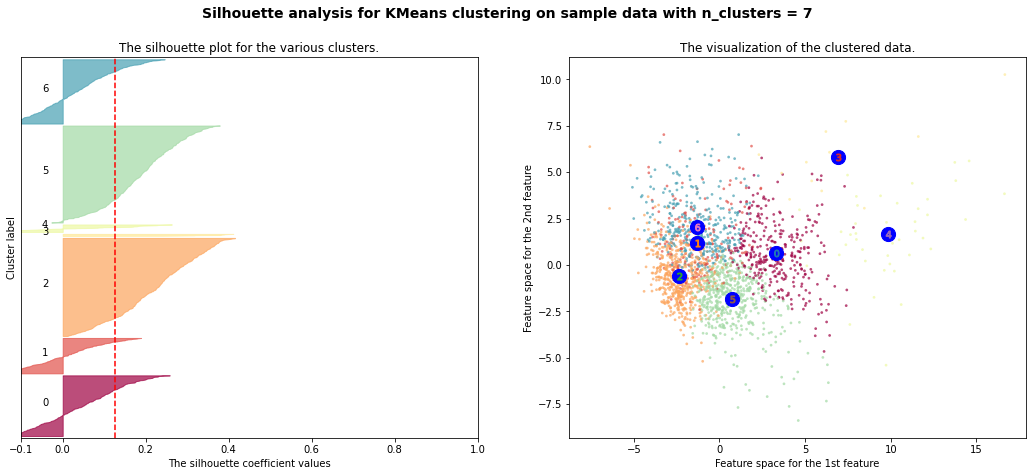

For n_clusters = 8 The average silhouette_score is : 0.10847233066249337


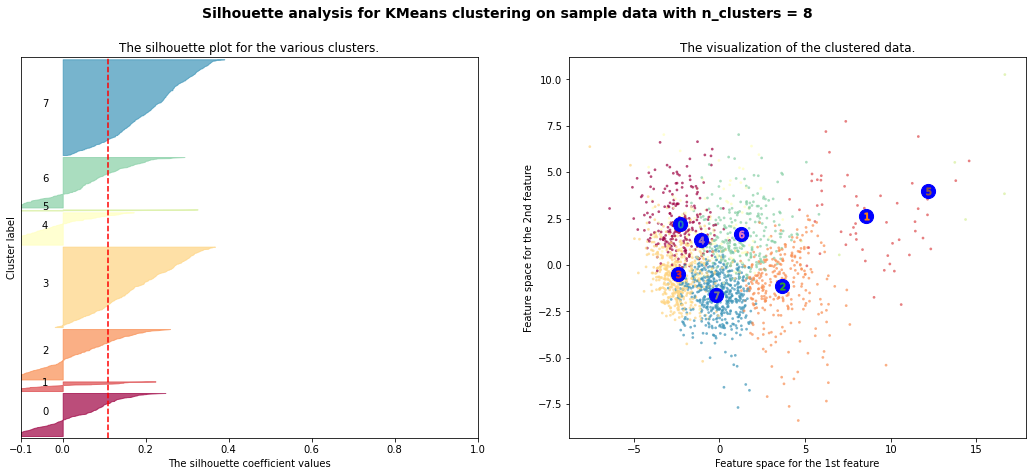

For n_clusters = 9 The average silhouette_score is : 0.1269243418998834


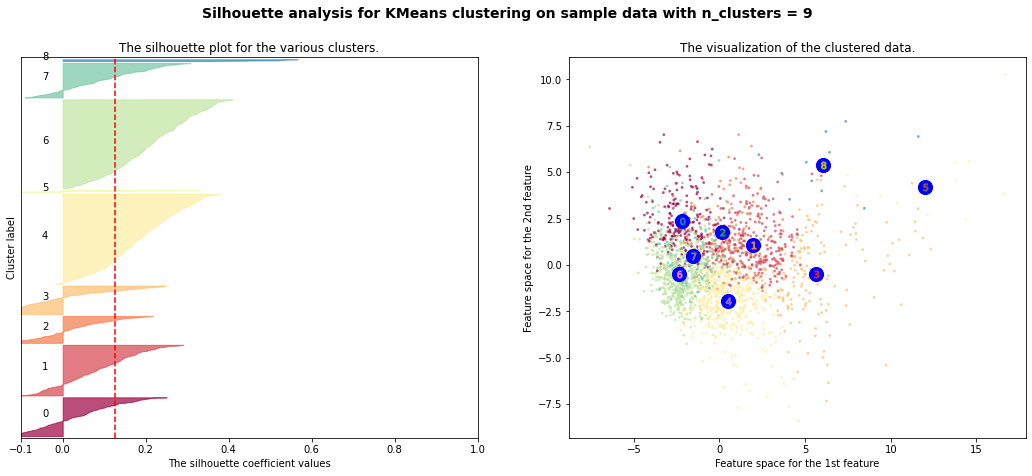

For n_clusters = 10 The average silhouette_score is : 0.1157356655497575


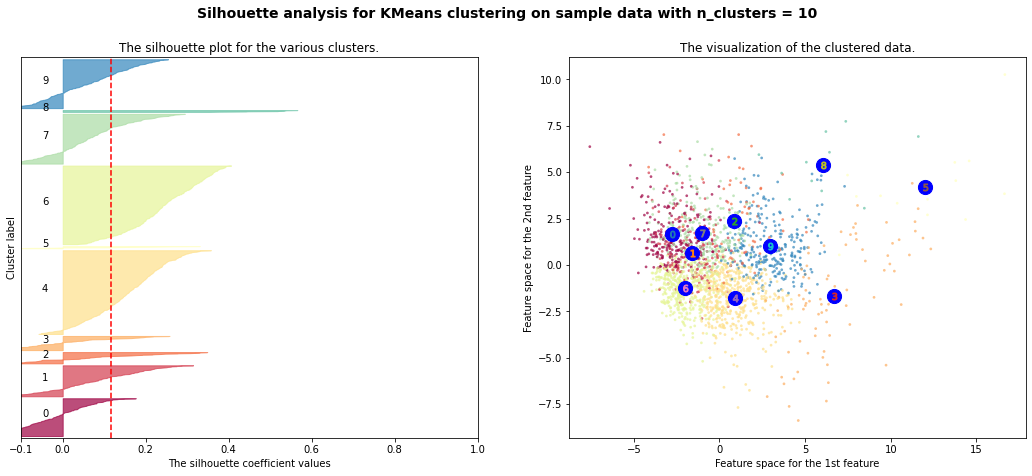

For n_clusters = 11 The average silhouette_score is : 0.11486382660201777


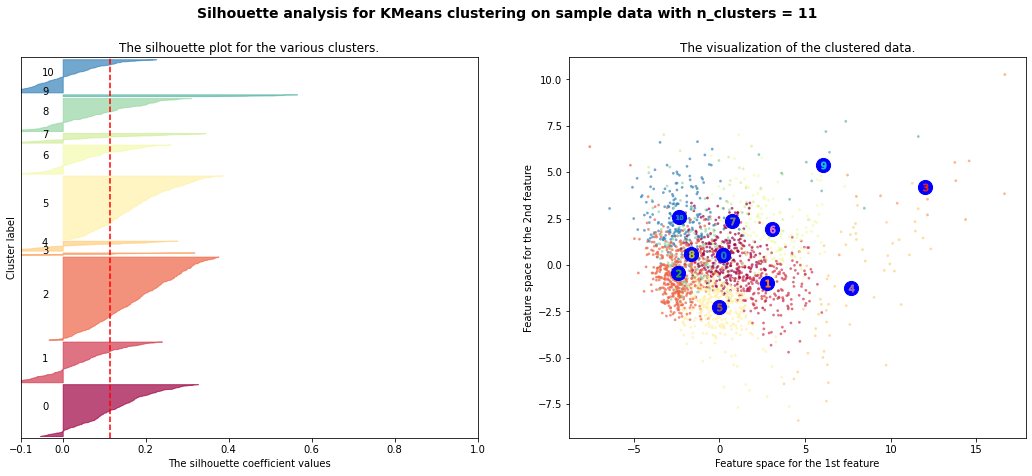

For n_clusters = 12 The average silhouette_score is : 0.10291000516030487


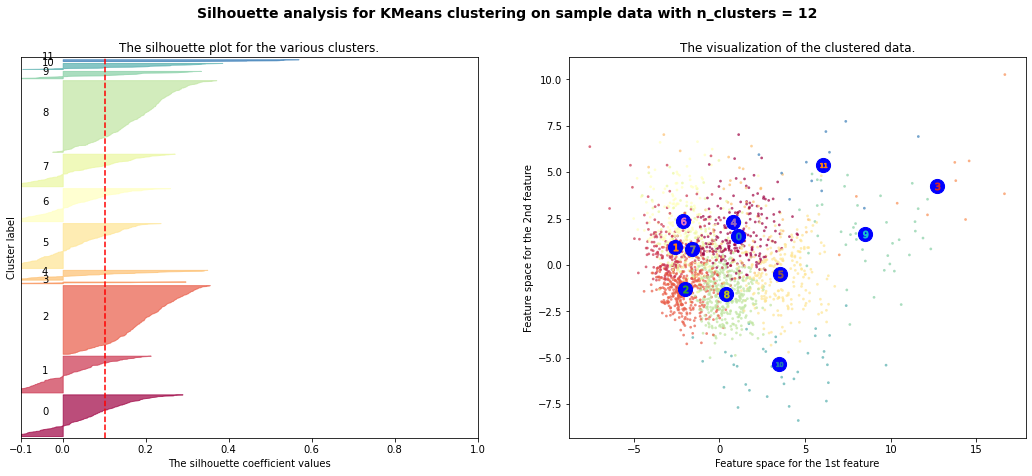

For n_clusters = 13 The average silhouette_score is : 0.1202111382746944


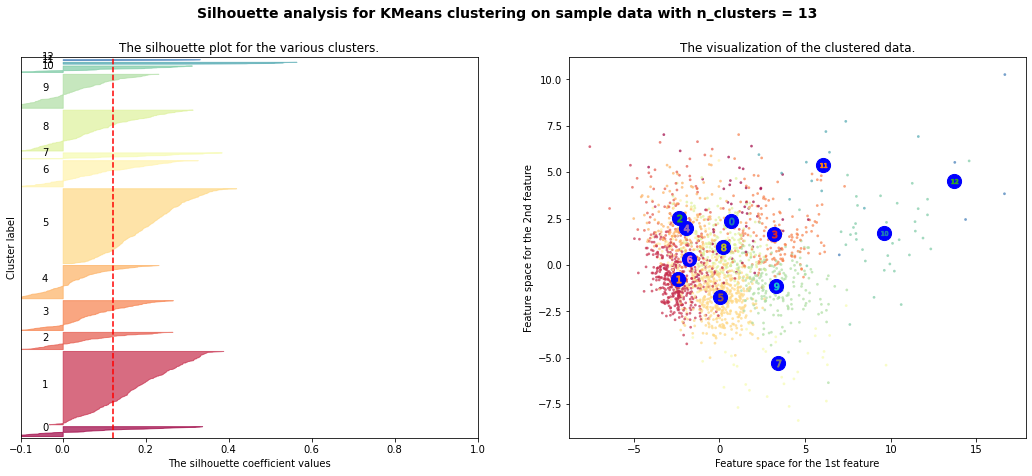

For n_clusters = 14 The average silhouette_score is : 0.10474116809636494


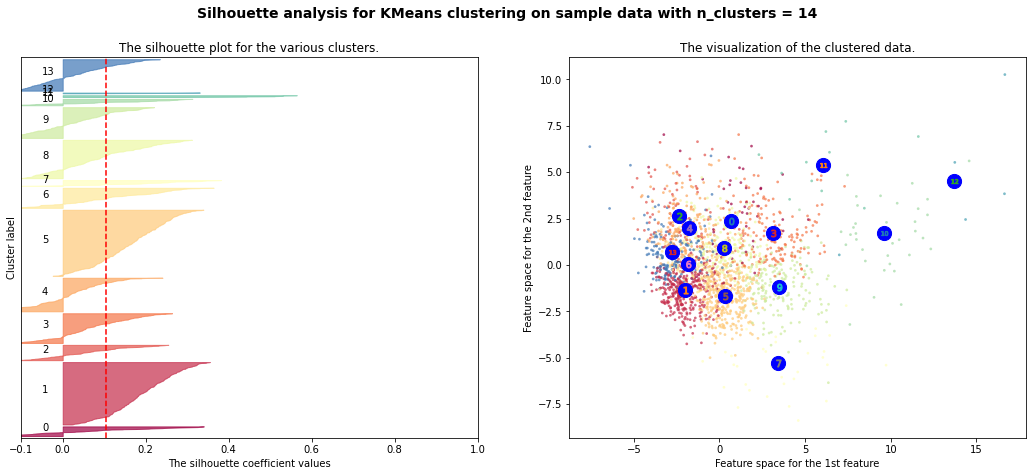

For n_clusters = 15 The average silhouette_score is : 0.1048853442993639


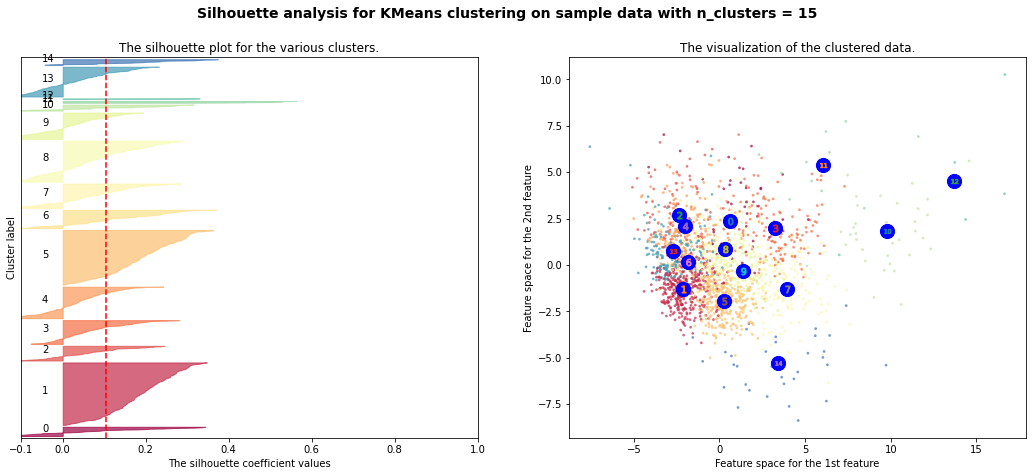

For n_clusters = 16 The average silhouette_score is : 0.09743054510254481


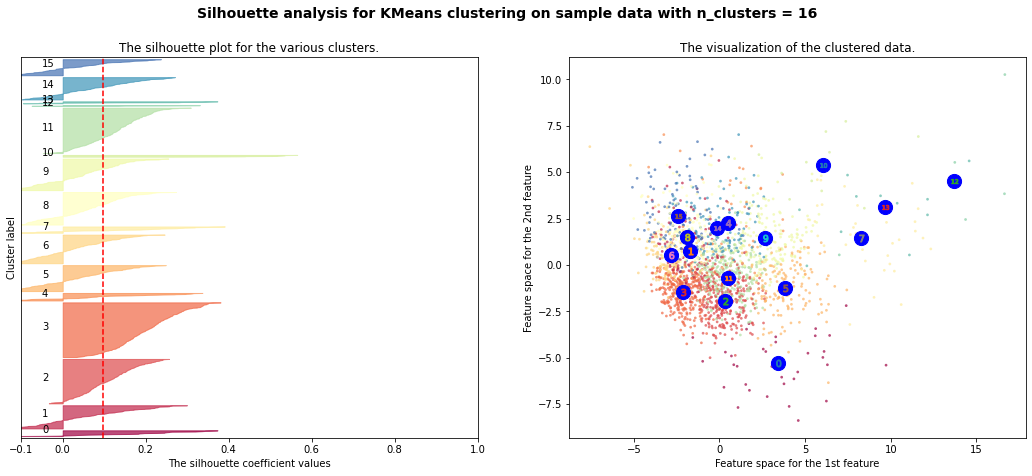

For n_clusters = 17 The average silhouette_score is : 0.08346098982753387


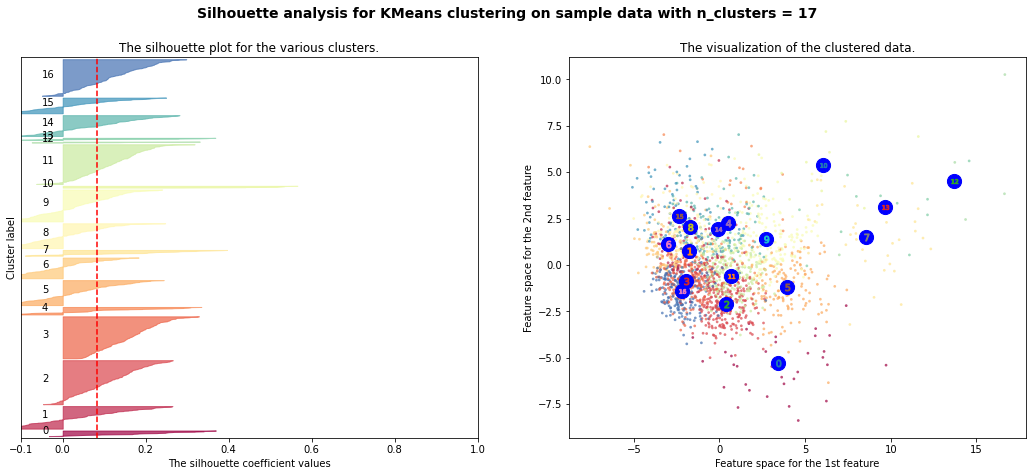

For n_clusters = 18 The average silhouette_score is : 0.08643827222322804


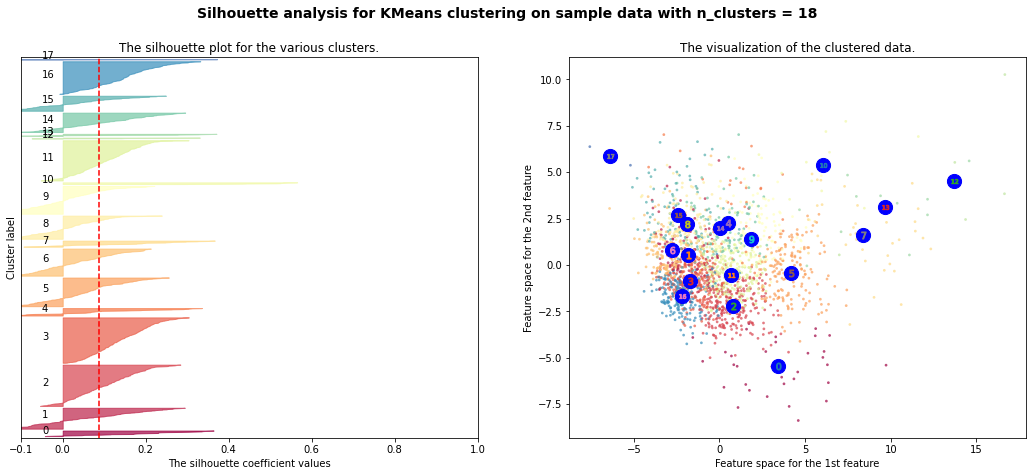

For n_clusters = 19 The average silhouette_score is : 0.09058536329908114


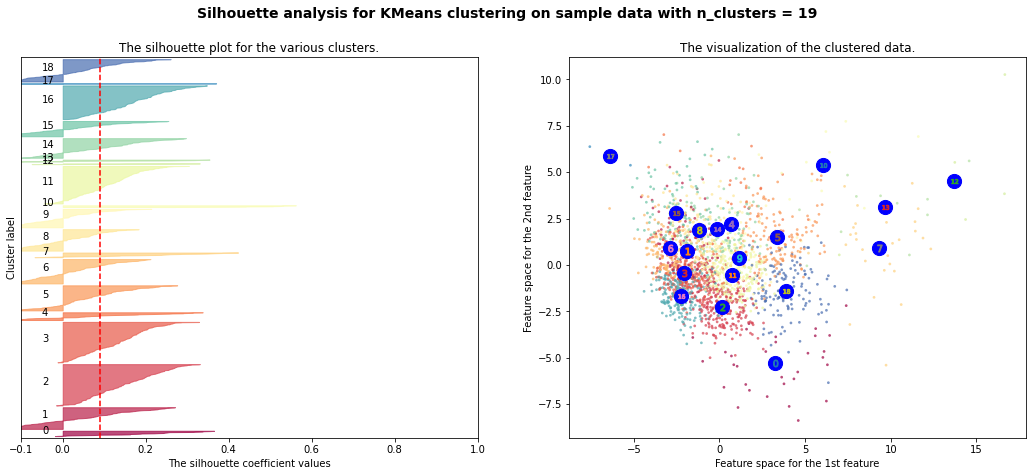

In [385]:
### PLOT Silhouette Charts
X = x
range_n_clusters = range(2,20)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed

    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="b", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

### Evaluate Gaussian Mixture - mixture_testing

In [9]:
def mixture_testing(df_scaled_pca, mink, maxk):
    x = np.array(df_scaled_pca)
    aic = np.zeros(maxk)
    score = np.zeros(maxk)
    converged = np.zeros(maxk)
    silhouette = np.zeros(maxk)
    
#     fig, axes = plt.subplots(5, 4, figsize=(16,9))

    # flatten
#     axes = [ax for axrow in axes for ax in axrow]

    for k in range(mink,maxk):
        model = GaussianMixture(n_components=k, n_init=15, max_iter=300)
        %time y = model.fit_predict(x)
    #     ax.axis('off')
    #     ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    #     ax.set_ylim(ymin=-9, ymax=8)
                
        if k > 1:
            aic[k] = model.aic(x)
            b = aic[aic!=0]
            converged[k] = model.converged_
#             silhouette[k] = silhouette_score(x,y)
            print(k)
            np.append(aic_tot, aic[k])
    fig, ax = plt.subplots()
    ax.plot(range(mink ,maxk), aic_tot[mink :maxk], 'o-')
    ax.set_xlabel("number of clusters")
    ax.set_ylabel("AIC Score (lower is better)")
    plt.title('Akaike Information Criterion')
    plt.tight_layout()
    plt.savefig(f'./img/gm_{mink}-{maxk}clusters_full.png', dpi=200)
    return aic, converged

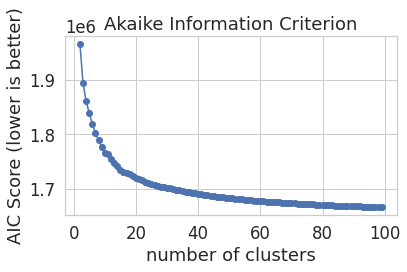

In [638]:
maxk = 100
mink = 2

fig, ax = plt.subplots()
ax.plot(range(mink ,maxk), aic_tot[mink :maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("AIC Score (lower is better)")
plt.title('Akaike Information Criterion')
plt.tight_layout()
plt.savefig(f'./img/gm_{mink}-{maxk}clusters_full.png', dpi=200)

# fig2, ax2 = plt.subplots()
# ax2.plot(range(20,maxk), score[20:maxk], 'o-')
# ax2.set_xlabel("number of clusters")
# ax2.set_ylabel("Log-Likelihood")
# plt.title('Log Likelihood for k')
# plt.savefig('./img/gm_56k.png')

Run Mixture Testing & Choose N components

In [636]:
aic, converged = mixture_testing(mstats, 40, 100)

CPU times: user 9min 23s, sys: 13min 41s, total: 23min 4s
Wall time: 3min 8s
40
CPU times: user 10min 53s, sys: 14min 34s, total: 25min 28s
Wall time: 3min 33s
41
CPU times: user 10min 51s, sys: 14min 52s, total: 25min 43s
Wall time: 3min 35s
42
CPU times: user 11min 20s, sys: 15min 21s, total: 26min 42s
Wall time: 3min 44s
43
CPU times: user 10min 54s, sys: 14min 57s, total: 25min 52s
Wall time: 3min 38s
44
CPU times: user 12min 18s, sys: 15min 55s, total: 28min 14s
Wall time: 3min 59s
45
CPU times: user 11min 38s, sys: 16min 6s, total: 27min 45s
Wall time: 3min 55s
46
CPU times: user 12min 20s, sys: 16min 58s, total: 29min 18s
Wall time: 4min 9s
47
CPU times: user 12min 14s, sys: 16min 45s, total: 29min
Wall time: 4min 7s
48
CPU times: user 12min 48s, sys: 17min 14s, total: 30min 2s
Wall time: 4min 17s
49
CPU times: user 12min 46s, sys: 17min 47s, total: 30min 33s
Wall time: 4min 21s
50
CPU times: user 13min 40s, sys: 17min 41s, total: 31min 22s
Wall time: 4min 33s
51
CPU times: user

In [637]:
aic_tot = np.append(aic_tot, aic[40:])

Train at best component number

In [10]:
gm = GaussianMixture(n_components=30, n_init=15, max_iter=300)
%time y = gm.fit_predict(mstats)
gm.aic(mstats)



CPU times: user 8min 32s, sys: 13min 21s, total: 21min 53s
Wall time: 2min 49s


1700864.5421857429

In [11]:
centers = gm.means_

In [12]:
list(playlist_analysis.columns)

[('danceability', 'std'),
 ('danceability', 'mean'),
 ('loudness', 'std'),
 ('loudness', 'mean'),
 ('mode', 'std'),
 ('mode', 'mean'),
 ('speechiness', 'std'),
 ('speechiness', 'mean'),
 ('acousticness', 'std'),
 ('acousticness', 'mean'),
 ('instrumentalness', 'std'),
 ('instrumentalness', 'mean'),
 ('liveness', 'std'),
 ('liveness', 'mean'),
 ('valence', 'std'),
 ('valence', 'mean'),
 ('tempo', 'std'),
 ('tempo', 'mean')]

In [13]:
gm.n_iter_

33

In [14]:
gm.aic(mstats)

1700864.5421857429

In [21]:
gm.score(mstats)

-12.22366861911335

Add Labels to Data

In [15]:
pa = playlist_analysis
pa['cluster'] = y


Label Playlist Master

In [17]:
pa['cluster']

playlist_name
   Ok              20
   bluegrass        4
 '16               15
 (Royalty)          9
 1-800-273-8255     9
                   ..
🥀🥀                 15
🦄🦄                  7
🦄🦄                 12
🦄🦄🦄                27
🦄🦄🦄                 9
Name: cluster, Length: 69422, dtype: int64

In [22]:
#merge playlists appended with labels to playlist master
playlist_labeled = playlist_master[:1000]named: 0.1' )
playlist_labeled.dropna(inplace=True)

### Fit KNN

In [63]:
knn = NearestNeighbors(n_neighbors=5, algorithm = 'auto')
knn.fit(mstats)

NearestNeighbors()

### Find Nearest Playlists from new Playlist

In [78]:
def new_playlist(uri, playlist_analysis, playlist_master):
    pl = spotify.playlist_items(uri, fields=None, market=None)
    plt = pd.DataFrame(pl['items'])
    lst = []
    songs = pd.DataFrame(columns=['track_uri'])
    for i in range(plt.shape[0]):
        lst.append(plt['track'][i]['uri'])
    
    splits = len(lst)
    if splits>200:
        num_splits = (splits//150)
    else:
        num_splits = 2

    start1 = 0
    end1 = splits//num_splits
    for k in range(2,num_splits+1):
        tracklist = lst[start1:end1]                             

        start1 = start1+end1+1
        end1 = end1*k
        if len(tracklist) > 0:
            track_req = spotify.audio_features(tracklist)

            tracks_df = pd.DataFrame(track_req)      
            tracks_df = tracks_df.rename(columns={"uri": "track_uri"})
            tracks_df.drop(['id', 'track_href', 'analysis_url', 'duration_ms'], axis=1, inplace=True)
            songs = songs.append(tracks_df)


    songs = songs.drop_duplicates(subset='track_uri')
    songs.drop(columns= ['type'], inplace=True)
    songs = songs[['danceability',
                     'key','loudness','mode','speechiness','acousticness','instrumentalness',
                     'liveness','valence','tempo']]
    songs = songs.agg({'danceability': [np.std, np.mean],
                        'loudness': [np.std, np.mean],
                        'mode': [np.std, np.mean],
                        'speechiness': [np.std, np.mean],
                        'acousticness': [np.std, np.mean],
                        'instrumentalness': [np.std, np.mean],
                        'liveness': [np.std, np.mean],
                        'valence': [np.std, np.mean],
                        'tempo': [np.std, np.mean]})
    songs = pd.DataFrame(songs.T.stack()).T
    songs = scaler.transform(np.array(songs).reshape(1,-1))
    indices = knn.kneighbors(songs, 5, return_distance=False)
            
    neighbors = pd.DataFrame()
    for i in indices[0]:
        neighbors = neighbors.append(playlist_master[playlist_master['playlist_name']==playlist_analysis.iloc[i].name])
        
    return neighbors

In [77]:
neighbors= new_playlist('https://open.spotify.com/playlist/6TeyryiZ2UEf3CbLXyztFA', playlist_analysis, playlist_master)

ValueError: Expected the input data X have 10 features, but got 18 features

In [80]:
for i in neighbors['playlist_name'].unique():
    print (i)

Dad's Playlist
Life
Dad playlist
In the Zone
psych 


In [69]:
for i in neighbors.groupby('artist_name').count().sort_values(by='playlist_name', ascending=False).index[:50]:
    print(i)

Pink Floyd
Rush
The Beatles
blink-182
Eminem
The Doors
A Boogie Wit da Hoodie
Lynyrd Skynyrd
Usher
Ozzy Osbourne
Metallica
The Rolling Stones
Jimi Hendrix
Black Veil Brides
AC/DC
Nirvana
Daddy Yankee
Eric Clapton
The Who
G-Eazy
Drake
Lil Uzi Vert
Maroon 5
Young Thug
Crystal Castles
Hoodie Allen
Incubus
Lil Pump
Kid Cudi
Grateful Dead
Palace
Lil Wayne
Scorpions
Travis Scott
Fetty Wap
Eagles
Three Days Grace
Wiz Khalifa
Evanescence
Justin Bieber
Akon
Queen
Cristian Castro
Guns N' Roses
NAV
Falling In Reverse
Alan Jackson
The Fray
Creedence Clearwater Revival
The Shins


In [73]:
neighbors[['playlist_name','artist_name','track_name', 'album_name']].head(500)

,playlist_name,artist_name,track_name,album_name
0,Dad's Playlist,Ted Nugent,Stranglehold,Ted Nugent
1,Dad's Playlist,Bon Jovi,Livin' On A Prayer,Slippery When Wet
2,Dad's Playlist,Ozzy Osbourne,Mr. Crowley,The Essential Ozzy Osbourne
3,Dad's Playlist,Dio,Holy Diver,Holy Diver
4,Dad's Playlist,Ozzy Osbourne,Crazy Train - Remastered,Blizzard of Ozz (Expanded Edition)
5,Dad's Playlist,Ozzy Osbourne,N.I.B.,Prince Of Darkness
6,Dad's Playlist,Guns N' Roses,Knockin' On Heaven's Door,Use Your Illusion II
7,Dad's Playlist,Mötley Crüe,Wild Side,"Girls, Girls, Girls"
8,Dad's Playlist,The Offspring,Defy You,Greatest Hits
9,Dad's Playlist,The Offspring,Coming for You,Coming for You


### Category Discovery

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mstats = scaler.fit_transform(playlist_analysis)

In [85]:
def cat_dict(centers):
    '''Generate dictionary of categories determined by KNN
    Make sure to use full set of features not just PCA or Scaler Error will occur
    
    centers: cluster centers from clustering model
    
    '''
    d = {}
    for i in range(len((centers))):
        center = scaler.transform(np.array(centers[i]).reshape(1,-1))
        indices = knn.kneighbors(center, 5, return_distance=False)
        neighbors = pd.DataFrame()
        for j in indices[0]:
            neighbors = neighbors.append(playlist_master[playlist_master['playlist_name']==playlist_analysis.iloc[j].name])

        d[i] = neighbors
    return d

In [36]:
def see_category_artists(d, cat_num):
    ''' View most common artists in category
    
    d: dictionary of cluster dataframes with category is key
    cat_num: Category number
    
    '''
    
    for i in d[cat_num].groupby('artist_name').count().sort_values(by='playlist_name', ascending=False).index[:50]:
        print(i)

In [56]:
see_category_artists(d, 18)

Marco Mengoni
Dario Marianelli
Tiziano Ferro
Louis Armstrong
NEEDTOBREATHE
Italian Mandolin Torna A Surriento
Rockabye Lullaby
Alan Farrington
Billie Holiday
Jazz Band Piano Blues
Italian Restaurant Music of Italy
Etta James
Ziggy Alberts
Sticky Fingers
Otis Redding
Kanye West
Baby K
Jovanotti
Tyler, The Creator
Dinah Shore
Tossing Copper
Dean Martin
Ben Howard
Lorde
Jo Stafford
Ella Fitzgerald
Elliott Smith
Sam Cooke
Arcade Fire
Mumford & Sons
Amber Run
Alexandre Desplat
Mac Demarco
Four Tops
Ocean Alley
Frank Sinatra
Kay Starr
Louis Armstrong & His All-Stars
Nico Muhly
AJJ
Young Thug
The Supremes
Ben Rector
Lana Del Rey
St. Vincent
Artie Shaw
La Paloma Guitars
Simon & Garfunkel
Bear's Den
Craig Armstrong


In [627]:
def see_category(cat_num):
    '''view category DataFrame'''
    return d[cat_num][['playlist_name','artist_name','track_name', 'album_name']].head(500)

In [628]:
see_category(0)

,playlist_name,artist_name,track_name,album_name
0,Friends,Eagles,Take It Easy,Eagles (Remastered)
1,Friends,The Smiths,Rubber Ring - 2011 Remastered Version,Louder Than Bombs
2,Friends,Lynyrd Skynyrd,The Ballad Of Curtis Loew,Second Helping
3,Friends,Crowded House,Don't Dream It's Over,Crowded House
4,Friends,Elton John,Your Song,Elton John
5,Friends,Metallica,The Call Of Ktulu - Remastered,Ride The Lightning
6,Friends,Iron Maiden,Run to the Hills - 1998 Remastered Version,The Number Of The Beast
7,Friends,When In Rome,The Promise,When In Rome
8,Friends,Led Zeppelin,Whole Lotta Love,Led Zeppelin II
9,Friends,Metallica,Ride The Lightning - Remastered,Ride The Lightning


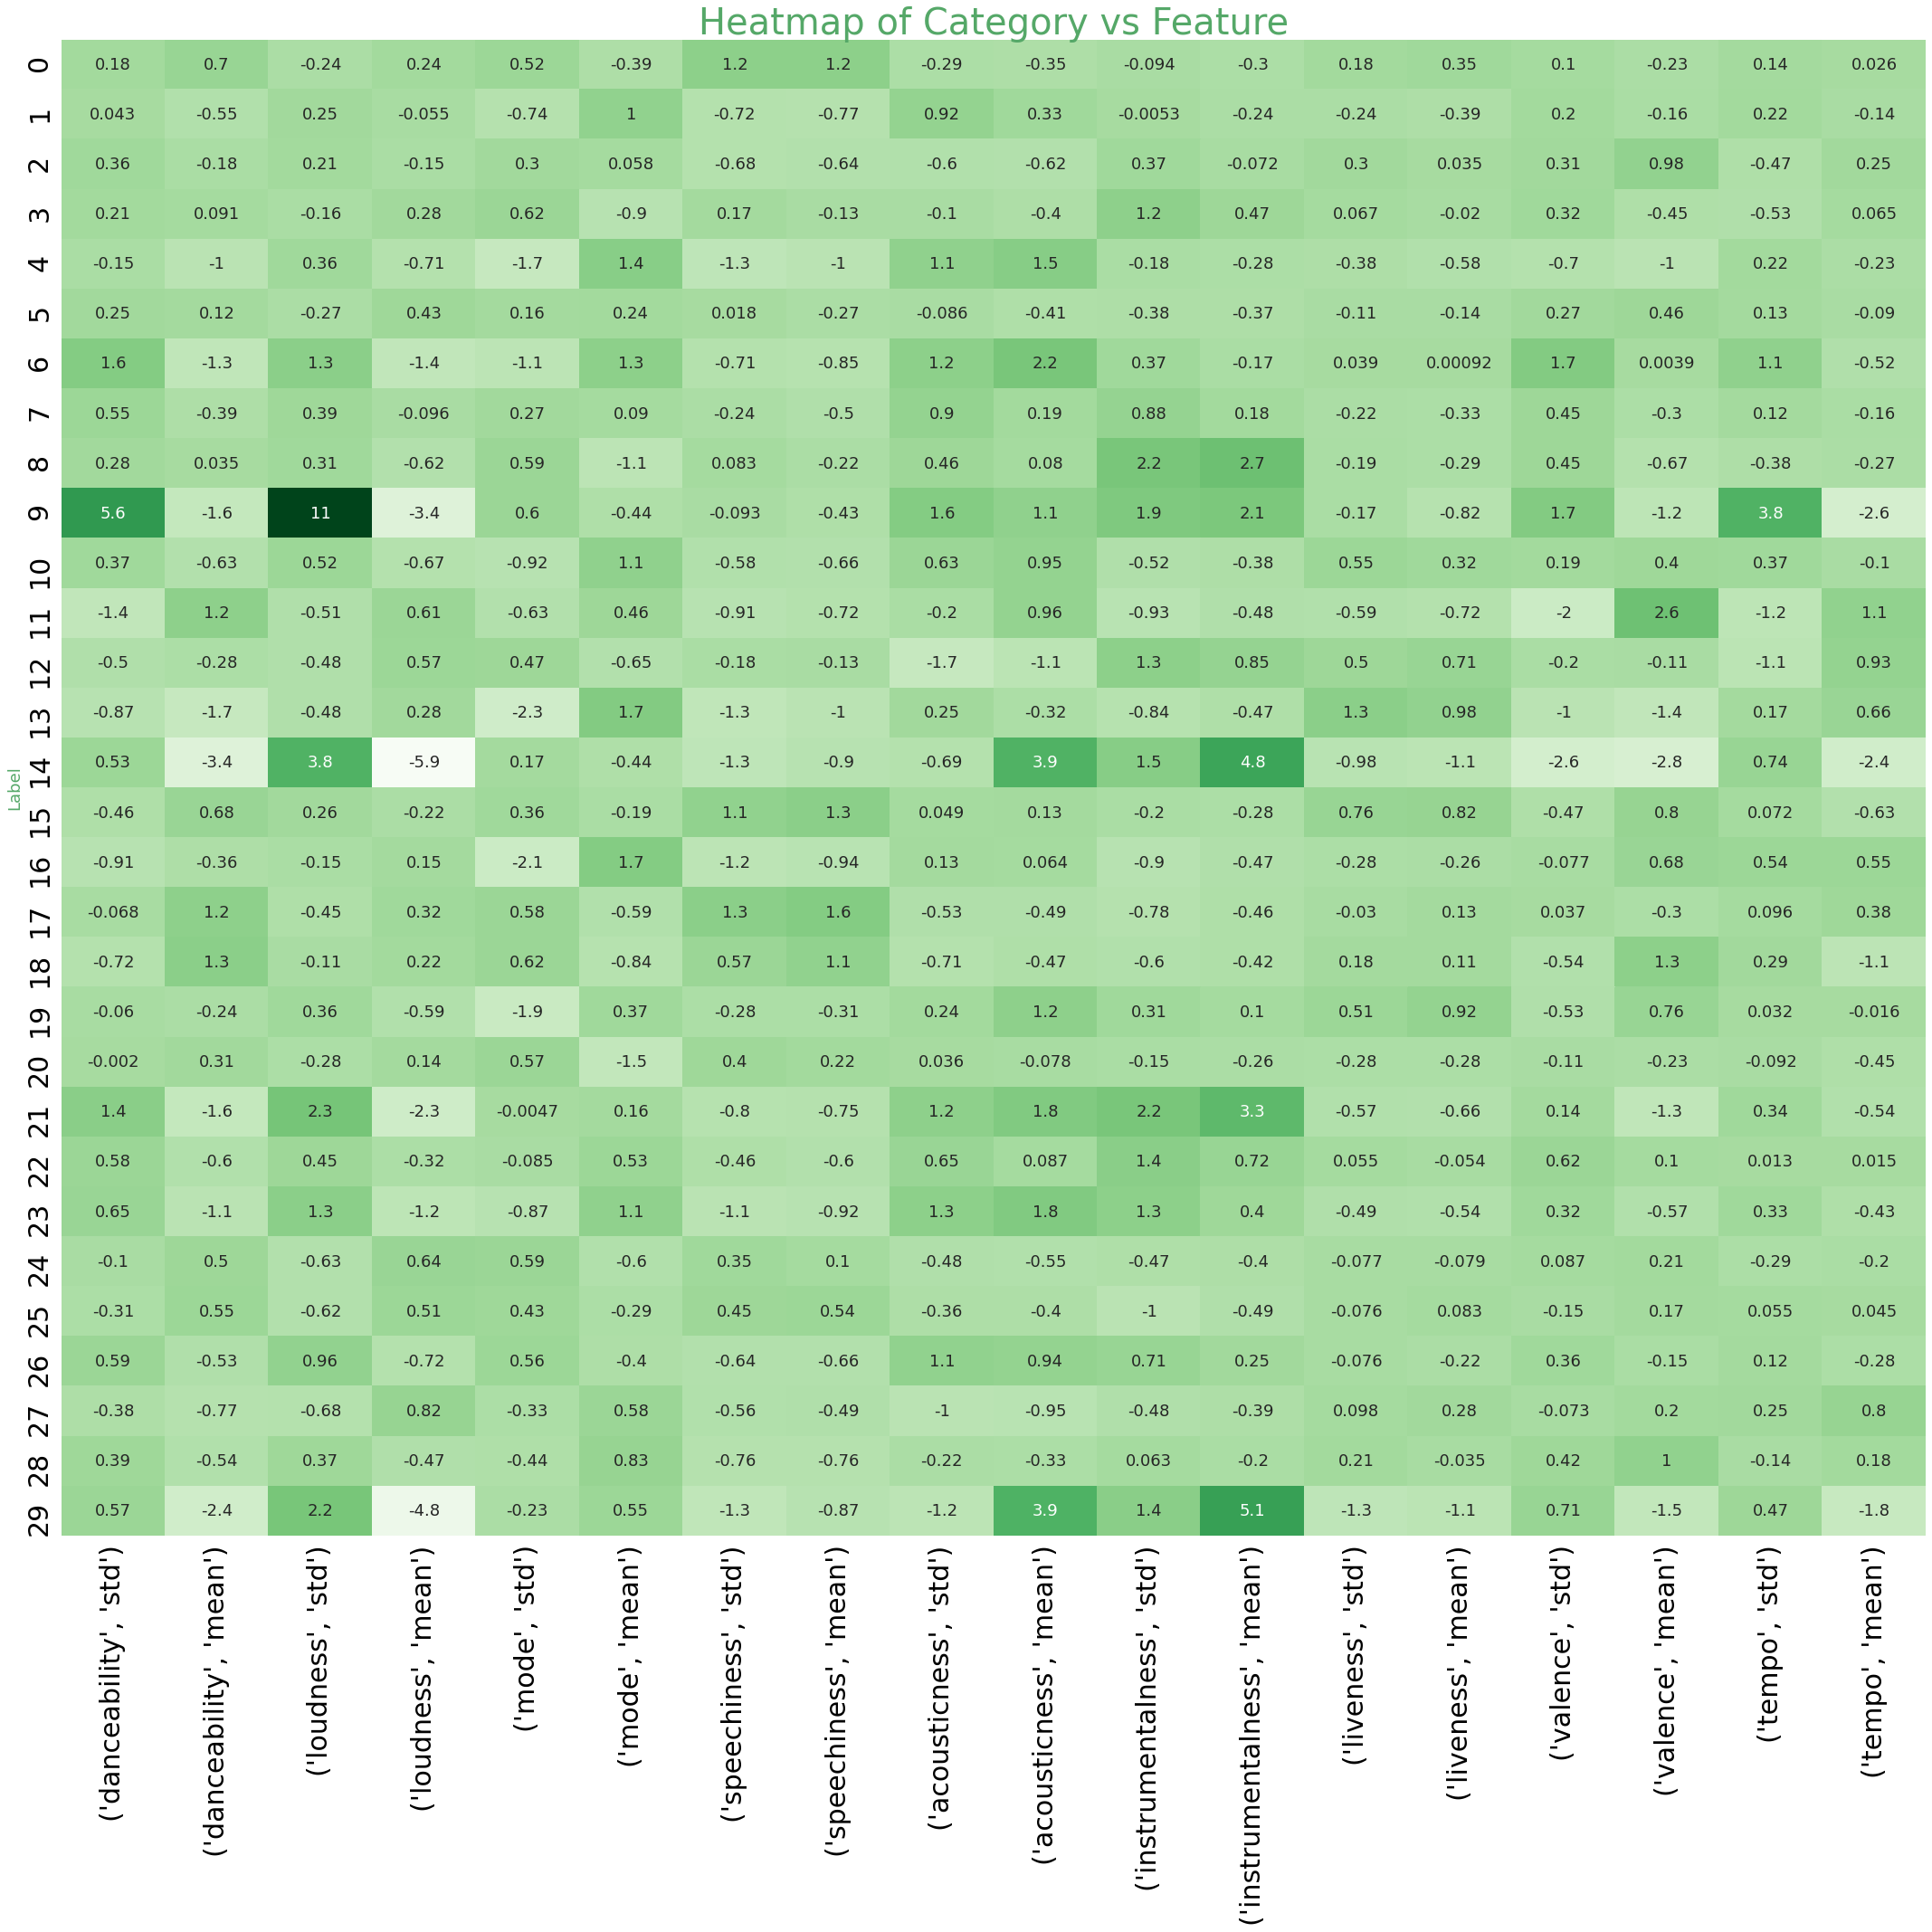

In [569]:
import seaborn as sns
plt.figure(figsize=(30,30))
sns.set(font_scale=1.5, style="whitegrid")
sns.heatmap(
    data= c,
    cmap='Greens',
    annot=True,
    cbar=False
    
)

plt.xticks(c='black', fontsize=30)
plt.yticks(c='black', fontsize=30)
plt.title("Heatmap of Category vs Feature", fontdict={'fontsize': 40}, color = 'g')
plt.ylabel("Label", c='g')

plt.tight_layout()
plt.savefig('heatmap_all.png', dpi=200)

array([[<AxesSubplot:title={'center':"('acousticness', 'mean')"}>,
        <AxesSubplot:title={'center':"('acousticness', 'std')"}>,
        <AxesSubplot:title={'center':"('danceability', 'mean')"}>,
        <AxesSubplot:title={'center':"('danceability', 'std')"}>],
       [<AxesSubplot:title={'center':"('instrumentalness', 'mean')"}>,
        <AxesSubplot:title={'center':"('instrumentalness', 'std')"}>,
        <AxesSubplot:title={'center':"('liveness', 'mean')"}>,
        <AxesSubplot:title={'center':"('liveness', 'std')"}>],
       [<AxesSubplot:title={'center':"('loudness', 'mean')"}>,
        <AxesSubplot:title={'center':"('loudness', 'std')"}>,
        <AxesSubplot:title={'center':"('mode', 'mean')"}>,
        <AxesSubplot:title={'center':"('mode', 'std')"}>],
       [<AxesSubplot:title={'center':"('speechiness', 'mean')"}>,
        <AxesSubplot:title={'center':"('speechiness', 'std')"}>,
        <AxesSubplot:title={'center':"('tempo', 'mean')"}>,
        <AxesSubplot:title={'cen

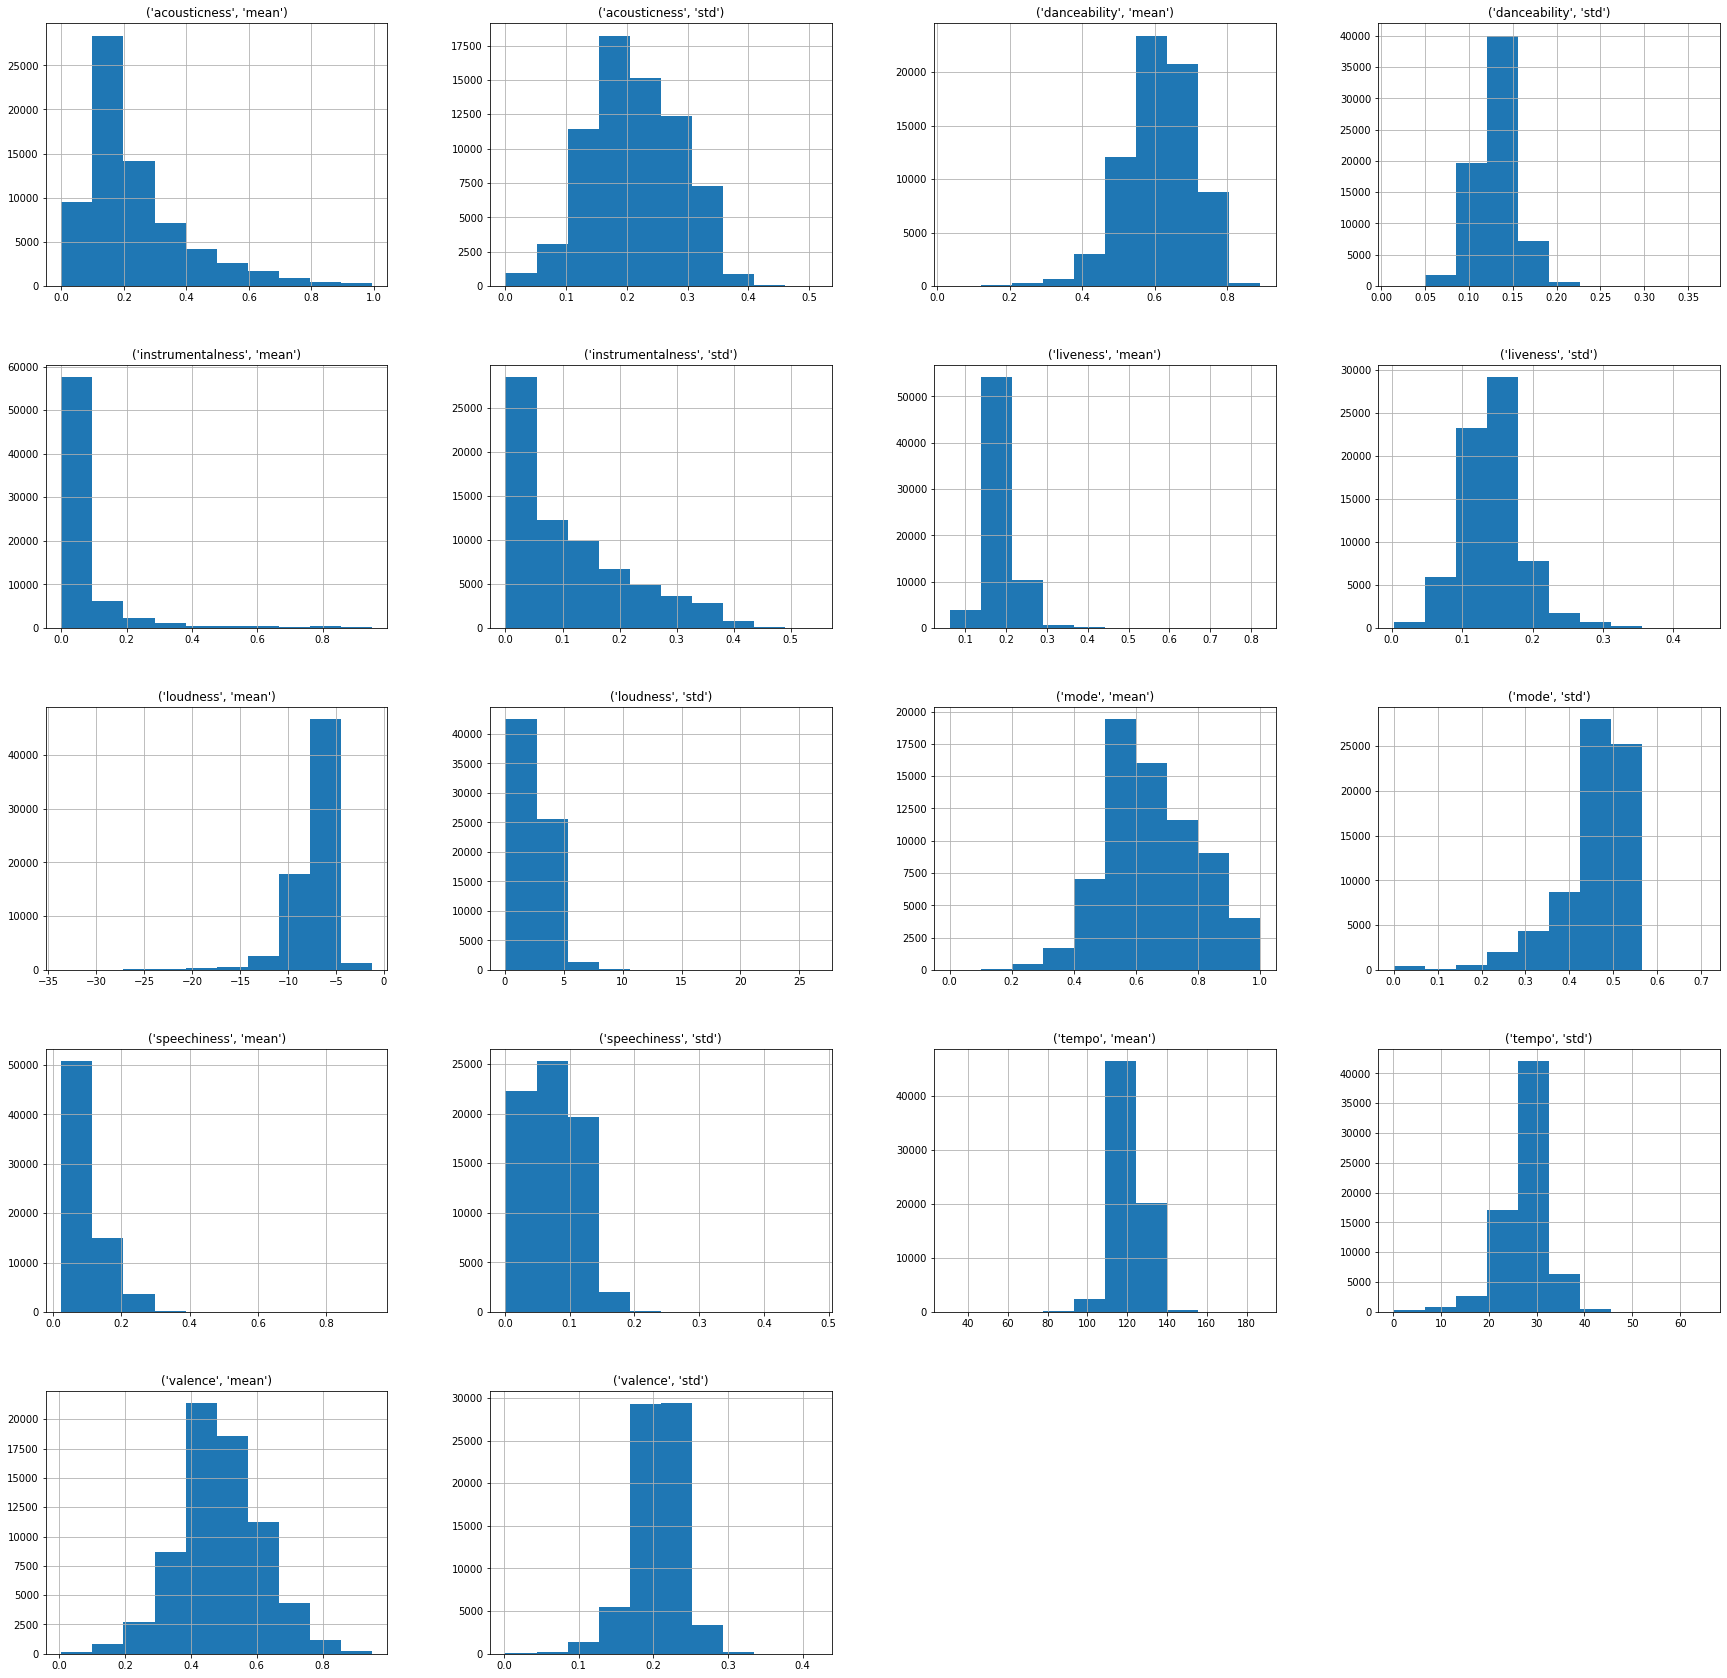

In [84]:
playlist_analysis.hist(figsize=(30,30))